In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from  sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble  import GradientBoostingClassifier 
from lightgbm import LGBMClassifier 
from  sklearn.model_selection import  train_test_split 

In [2]:
data = pd.read_csv('./preprocesss_train_test_all.csv')

In [3]:
train_size = len(data) -2968
train_data   = data.iloc[ 0:train_size , :]
test_data = data.iloc[train_size: ,: ] 
train_data = train_data.drop( ['id'] ,axis =1   )

test_sub= test_data.loc[ :, ['id']]
test_data  = test_data.drop( ['id' , 'happiness' ] ,axis =1   ) 

In [4]:
y_train ,x_train =  train_data['happiness'] ,train_data.drop( 'happiness' ,axis =1 )
x_test = test_data

In [5]:
y_train =y_train.astype('int64') -1 

In [6]:
X_train,X_valid, Y,Y_valid = train_test_split(x_train , 
                                              y_train ,
                                              test_size = 0.2 ,
                                              random_state  = 17  )
print (X_train.shape , X_valid.shape , Y.shape , Y_valid.shape)

(6400, 133) (1600, 133) (6400,) (1600,)


In [7]:
from deepctr.models import DeepFM
from sklearn.preprocessing import LabelEncoder 
from deepctr.inputs import SparseFeat ,get_feature_names
from tensorflow.keras.optimizers import SGD ,Adam

# 对特征标签进行编码
sparse_features =  X_train.columns.to_list()

for feature in sparse_features:
    lbe = LabelEncoder()
    data[feature] = lbe.fit_transform(data[feature])

fixlen_feature_columns =[]
for  feature in sparse_features :
# 计算每个特征中的 不同特征值的个数
    if data[feature].nunique() > 10 :
        embedding_dim = 8
    else:
        embedding_dim = data[feature].nunique() 
    fixlen_feature_columns = [SparseFeat(feature,  embedding_dim ) ]
print(fixlen_feature_columns)
linear_feature_columns = fixlen_feature_columns
dnn_feature_columns = fixlen_feature_columns
feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)


train_model_input = {name:X_train[name].values for name in feature_names}
valid_model_input = {name:X_valid[name].values for name in feature_names}


# 使用DeepFM进行训练
model = DeepFM(linear_feature_columns,
               dnn_feature_columns  ,
                task='regression' )

model.compile('adam' , "mse", metrics= ['mse' ,])
history = model.fit(train_model_input,
                    Y.values,
                    batch_size= 128, 
                    epochs=10,
                    verbose=True,
                    validation_data = (valid_model_input , Y_valid))

[SparseFeat(name='family_income_cut', vocabulary_size=6, embedding_dim=4, use_hash=False, dtype='int32', embedding_name='family_income_cut', group_name='default_group')]
Train on 6400 samples, validate on 1600 samples
Epoch 1/10


C:\ProgramData\Anaconda3\envs\tf2\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


 128/6400 [..............................] - ETA: 26s - loss: 8.4766 - mse: 8.4766

C:\ProgramData\Anaconda3\envs\tf2\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


6400/6400 [==============================] - 1s 126us/sample - loss: 4.8736 - mse: 4.8736 - val_loss: 0.5160 - val_mse: 0.5160
Epoch 2/10
6400/6400 [==============================] - 0s 19us/sample - loss: 0.4538 - mse: 0.4538 - val_loss: 0.4621 - val_mse: 0.4621
Epoch 3/10
6400/6400 [==============================] - 0s 23us/sample - loss: 0.4087 - mse: 0.4087 - val_loss: 0.4615 - val_mse: 0.4615
Epoch 4/10
6400/6400 [==============================] - 0s 19us/sample - loss: 0.4089 - mse: 0.4089 - val_loss: 0.4623 - val_mse: 0.4623
Epoch 5/10
6400/6400 [==============================] - 0s 22us/sample - loss: 0.4091 - mse: 0.4091 - val_loss: 0.4637 - val_mse: 0.4637
Epoch 6/10
6400/6400 [==============================] - 0s 25us/sample - loss: 0.4099 - mse: 0.4099 - val_loss: 0.4615 - val_mse: 0.4615
Epoch 7/10
6400/6400 [==============================] - 0s 15us/sample - loss: 0.4088 - mse: 0.4088 - val_loss: 0.4616 - val_mse: 0.4616
Epoch 8/10
6400/6400 [=============================

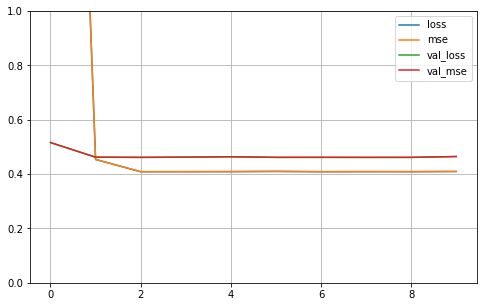

In [8]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1 )
    plt.show()

plot_learning_curves(history)

In [9]:
test_input = {name:x_test[name].values for name in feature_names}
predcit_deepfm = model.predict(test_input ,batch_size=  128)
predcit_deepfm = predcit_deepfm.ravel()
predcit_deepfm

array([2.9547682, 2.8957386, 2.9547682, ..., 2.9547682, 2.9547682,
       3.0567198], dtype=float32)

In [12]:
result=list(predcit_deepfm)
result=list(map(lambda x: x + 1, result))
test_sub["happiness"]=result
test_sub.to_csv("submit_01.csv", index=False)

In [13]:
test_sub

,id,happiness
8000,8001,3.954768
8001,8002,3.895739
8002,8003,3.954768
8003,8004,4.056720
8004,8005,3.954768
...,...,...
10963,10964,3.954768
10964,10965,3.895739
10965,10966,3.954768
10966,10967,3.954768
